# Physical model of airflow

In [1]:
# prompt: sam as above, but now also computing as flow f=- (alpha / v_current) * A_current * np.sign(p - p0) * np.sqrt(abs(p - p0)). and also plot it with the other variables
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the parameters
alpha = 30.0  # Parameter alpha
tf = 1.0    # Final time
p0 = 1    # Setpoint

# Define the time vector
t = np.linspace(0, 1.5* tf, 10000)

In [3]:
# Define the sigmoid function
def sigmoid(x, k, x0):
  """
  Sigmoid function.

  Args:
    x: Input value.
    k: Steepness of the sigmoid.
    x0: Center of the sigmoid.

  Returns:
    The sigmoid value.
  """
  return 1 / (1 + np.exp(-k * (x - x0)))

In [4]:
# Define the step function for A using sigmoid
k = 200  # Steepness of the sigmoid
x0_on = 0.5 * tf  # Center of the sigmoid for turning on  0.5
x0_off = .65 * tf  # Center of the sigmoid for turning off 0.95
A_on = sigmoid(t, k, x0_on)
A_off = 1 - sigmoid(t, k, x0_off)
A = A_on * A_off  # Combine the sigmoids to create the desired step function

In [5]:
# Calculate the indices where t <= tf
indices = t <= tf

# Assign values to v only where t <= tf
v = np.zeros_like(t)
vp = np.zeros_like(t)
v[indices] = 10 - np.sin(np.pi * t[indices] / tf)
vp[indices] = -np.pi * np.cos(np.pi * t[indices] / tf) / tf

# Initialize the pressure
p = np.zeros_like(t)
p = p + p0

In [6]:
# Define the differential equation
def dp_dt(p, v_current, v_previous, A_current):
  """
  Calculates the derivative of pressure with respect to time.

  Args:
    p: Current pressure value.
    v_current: Current velocity value.
    v_previous: Previous velocity value.
    A_current: Current value of the step function.

  Returns:
    The derivative of pressure with respect to time.
  """
  # Use v_current instead of v
  return -p * (v_previous) / v_current - (alpha / v_current) * A_current * np.sign(p - p0) * np.sqrt(abs(p - p0))

In [7]:
# Define the RK4 method
def rk4(f, p, v_current, v_previous, A_current, dt):
  """
  Applies the RK4 method to solve the differential equation.

  Args:
    f: The differential equation function.
    p: Current pressure value.
    v_current: Current velocity value.
    v_previous: Previous velocity value.
    A_current: Current value of the step function.
    dt: Time step.

  Returns:
    The updated pressure value.
  """
  k1 = dt * f(p, v_current, v_previous, A_current) # Pass individual values to dp_dt
  k2 = dt * f(p + k1 / 2, v_current, v_previous, A_current) # Pass individual values to dp_dt
  k3 = dt * f(p + k2 / 2, v_current, v_previous, A_current) # Pass individual values to dp_dt
  k4 = dt * f(p + k3, v_current, v_previous, A_current) # Pass individual values to dp_dt
  return p + (k1 + 2 * k2 + 2 * k3 + k4) / 6

In [8]:
# Integrate the differential equation using RK4
for i in range(1, len(t)):
  dt = t[i] - t[i - 1]
  p[i] = rk4(dp_dt, p[i-1], v[i], vp[i], A[i], dt) # Pass individual values to rk4 and use p[i-1]

# Calculate the flow
f =  (alpha / v) * A * np.sign(p - p0) * np.sqrt(abs(p - p0))

/tmp/ipykernel_21492/2635502671.py:16: RuntimeWarning: invalid value encountered in scalar divide
  return -p * (v_previous) / v_current - (alpha / v_current) * A_current * np.sign(p - p0) * np.sqrt(abs(p - p0))
/tmp/ipykernel_21492/2635502671.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  return -p * (v_previous) / v_current - (alpha / v_current) * A_current * np.sign(p - p0) * np.sqrt(abs(p - p0))
/tmp/ipykernel_21492/2635502671.py:16: RuntimeWarning: invalid value encountered in scalar multiply
  return -p * (v_previous) / v_current - (alpha / v_current) * A_current * np.sign(p - p0) * np.sqrt(abs(p - p0))
/tmp/ipykernel_21492/3505654910.py:7: RuntimeWarning: divide by zero encountered in divide
  f =  (alpha / v) * A * np.sign(p - p0) * np.sqrt(abs(p - p0))
/tmp/ipykernel_21492/3505654910.py:7: RuntimeWarning: invalid value encountered in multiply
  f =  (alpha / v) * A * np.sign(p - p0) * np.sqrt(abs(p - p0))


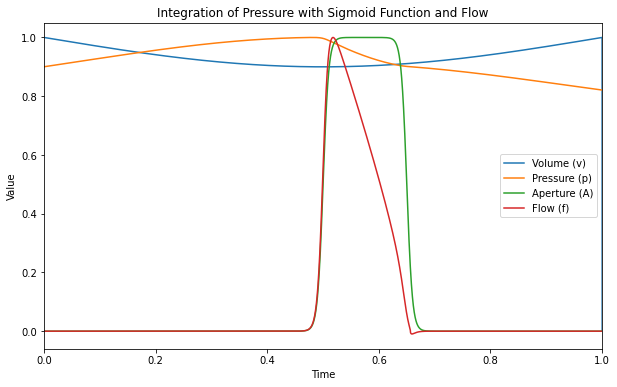

In [9]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, v/max(v), label='Volume (v)')
plt.plot(t, p/max(p), label='Pressure (p)')
plt.plot(t, A, label='Aperture (A)')
plt.plot(t, f/max(f), label='Flow (f)')
plt.xlim(0.,1.0)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Integration of Pressure with Sigmoid Function and Flow')
plt.grid(False)
plt.legend()
plt.show()
